# <center> Projet Nº 7 </center>


## <center> Effectuer une prédiction de revenus </center>

Vous êtes employé dans une banque, présente dans de nombreux pays à travers le monde. Celle-ci souhaite cibler de nouveaux clients potentiels, plus particulièrement les jeunes en âge d'ouvrir leur tout premier compte bancaire.

Cependant, elle souhaite cibler les prospects les plus susceptibles d'avoir, plus tard dans leur vie, de hauts revenus.

L'équipe dans laquelle vous travaillez a donc reçu pour mission de créer un modèle permettant de déterminer le revenu potentiel d'une personne.

Très bien.

"Quelles informations avons-nous ?" demandez-vous à votre supérieur, qui vous répond : "À vrai dire... quasiment aucune : uniquement le revenu des parents, car nous allons cibler les enfants de nos clients actuels, ainsi que le pays où ils habitent. C'est tout ! Ah oui, une dernière chose : ce modèle doit être valable pour la plupart des pays du monde. Je vous laisse méditer là-dessus… Bon courage !"
Avec aussi peu de données disponibles, cela semble être un sacré challenge !
Ainsi, vous proposez une régression linéaire avec 3 variables :

- le revenu des parents ;
- le revenu moyen du pays dans lequel habite le prospect ;
- l'indice de Gini calculé sur les revenus des habitants du pays en question.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')
#pd.set_option('display.max_rows', None)
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn import preprocessing
from function import *
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor

> ### Importation des DataFrames

In [2]:
data = pd.read_csv("../data/data-projet7.csv", decimal=",")
dataframe = pd.read_csv('../data/popu.csv')
df_gini = pd.read_csv('../data/gini.csv', skiprows=4)
coef_elasticite = pd.read_csv('../data/GDIM.csv', usecols=['countryname', 'iso3', 'region', 'IGEincome'])

> ### Exploration des Données


In [3]:
data.rename(columns={'year_survey': 'year'}, inplace=True)
data.head(2)

,country,year,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,728.89795,7297.0
1,ALB,2008,2,100,916.66235,7297.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11599 entries, 0 to 11598
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       11599 non-null  object 
 1   year          11599 non-null  int64  
 2   quantile      11599 non-null  int64  
 3   nb_quantiles  11599 non-null  int64  
 4   income        11599 non-null  float64
 5   gdpppp        11399 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 543.8+ KB


In [5]:
data_duplicates = data.duplicated()
print('Nombre des doublons {}'.format(data_duplicates.sum()))
print(str(len(data['country'].unique())) + ' List pays code pays / Pays')

Nombre des doublons 0
116 List pays code pays / Pays


**Observation :**
- Les pays doivent disposer 100 quantitles, **le dataframe renvoie 116 pays pour 11599 observations**, il manque un quantille dans l'observations.

In [6]:
# verification du quantile manquent
missing_quantile = data.groupby('country').nunique()
missing_quantile[missing_quantile['quantile'] < 100]
ltu = data[data['country'] == 'LTU']

## On va trouver le quantile manquent
liste_verif = ltu["quantile"].unique()
liste_verif[np.isin(np.arange(1,100,1), ltu['quantile'].unique())]
# Function
def find_missing(data):
    return [x for x in range(data[0], data[-1] + 1) if x not in data]
print(find_missing(liste_verif))

[41]


In [7]:
def show_n_missing(df, column):
    missing = []
    for x in list((df['country']).unique()):
        n_missing = sum(df[df['country'] == x][column].isnull())
        
        if n_missing > 0:
            missing.append(x)
            print(x, "-", n_missing)
            
    return missing
show_n_missing(data, 'gdpppp')

XKX - 100
PSE - 100


['XKX', 'PSE']

In [8]:
# On va verifier la valeur manqent et l'année pour la colonne 'GDPPPP'
missing_gdp = pd.isnull(data['gdpppp'])
m_gdp = data[missing_gdp]
m_gdp.groupby('year').max()

,country,quantile,nb_quantiles,income,gdpppp
year,,,,,
2008,XKX,100,100,7609.5760,NaN
2009,PSE,100,100,6343.8755,NaN


**Observation:**
- Le quantile manquent correspondé á la **Lithuani (quantile 41)** pour l'année **2008**.
- On trouve deux valeurs manquent dans la colonne **gdpppp** que correspondent aux pays et pour les années:
-- Ksovo (XKX) - 2008
-- Gaza (PSE) - 2009

> ### Nettoyage des Données

In [9]:
################################## Dataframe World income Distribution ############################################
# Calcule du quantile manquent par la median (4882.14065)
quant_41 = ltu[(ltu['quantile'] == 40) | (ltu['quantile'] == 42)]['income'].median()
# création de la ligne manquent pour le pays LTU quantile 41
data = data.append({'country': 'LTU', 'year': 2008, 'quantile': 41, 'nb_quantiles': 100,
                   'income': 4882.14065, 'gdpppp': 17571.0}, ignore_index=True)

# valeurs manquents 'gdpppp' pour Gaza et Kosovo
# Gaza 2009 : 3951.235
# Kosovo 2008 : 7249.357
# Source : https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.CD?locations=XK
data.loc[(data['gdpppp'].isna() == True) & (data['country'] == 'XKX'), 'gdpppp'] = 7249.357
data.loc[(data['gdpppp'].isna() == True) & (data['country'] == 'PSE'), 'gdpppp'] = 3951.235

################################# Dataframe Population ##################################################################
population = dataframe.loc[dataframe['série Name'] == 'Population, total']

# Selection des colonnes dont on a besoin
popu = population[['pays Code', '2004 [YR2004]', '2006 [YR2006]', '2007 [YR2007]', '2008 [YR2008]', '2009 [YR2009]',
                   '2010 [YR2010]', '2011 [YR2011]']]

# On rénome les colonnes
popu.rename(columns={'pays Code': 'country', '2004 [YR2004]': '2004', '2006 [YR2006]': '2006',
                   '2007 [YR2007]': '2007', '2008 [YR2008]': '2008', '2009 [YR2009]': '2009',
                   '2010 [YR2010]': '2010', '2011 [YR2011]': '2011'}, inplace=True)

# On va utiliser la function pd.melt pour avoir une tidy dataframe 
df_popu = pd.melt(popu, id_vars=['country'], var_name='year', value_name='population')

# On transforme les colonnes year et population en int
df_popu.population = df_popu.population.astype('int64')
df_popu.year = df_popu.year.astype('int64')

# On va faire la jointure des deux dataframes
df = pd.merge(data, df_popu, on=['country', 'year'], how='left')

# On remplie les valeurs manquent pour l'année 2008 pays Taiwan
values = {'year': 2008, 'population':23019.045}
df.iloc[10399:10499, :].fillna(value=values, inplace=True)

###################################### Indice de gini ####################################################################
gini_years = ['2004', '2006', '2007', '2008', '2009', '2010', '2011']
df_gini = pd.melt(df_gini, id_vars = ['Country Code', 'Country Name'], value_vars = gini_years, var_name = 'year',
              value_name = 'gini')
df_gini.rename(columns={'Country Code':'country', 'Country Name':'country_code'}, inplace=True)
df_gini['gini'] = round(df_gini['gini']/100, 2)
df_gini.dropna(inplace=True)
df_gini['year'] = df_gini['year'].astype(int)

# On va faire la jointure des deux dataframes
dataframe = pd.merge(df, df_gini, how='left', on=['country', 'year'])

######## Calcule de l'indice de gini pour les valeurs manquents
list_gini = []
for arr in dataframe['country']:
    gini_sub = dataframe.loc[dataframe['country'] == arr]['income'].values
    n = len(gini_sub)
    lorenz = np.cumsum(np.sort(gini_sub)) / gini_sub.sum()
    AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n
    S = 0.5 - AUC
    gini = round(2*S, 2) 
    list_gini.append(gini)
    
dataframe.loc[:,'gini'] = list_gini

###################################### GDMI ####################################################################

# Base de donnée GDIM
coef_elasticite.drop_duplicates(inplace=True)
coef_elasticite.drop_duplicates(subset=['iso3'], keep = 'last', inplace=True)

coef_elasticite = coef_elasticite.groupby(['iso3', 'region']).mean().reset_index()
# Imputation par la mediane
region = coef_elasticite.groupby('region').mean()
for region_name in region.index:
    coef_elasticite.loc[(coef_elasticite['region'] == region_name)
                       & (coef_elasticite['IGEincome'].isna()), ['IGEincome']] = region.loc[region_name][0]
    
coef_elasticite = coef_elasticite.round(1)
#coef_elasticite.head()
coef_elasticite.rename(columns={'iso3': 'country'}, inplace=True)

# On va faire la jointure entre les datasets
df_final = pd.merge(dataframe, coef_elasticite[['country', 'IGEincome']], on='country', how='left')
df_final.drop(['country_code'], axis = 'columns', inplace = True)
#df_final.head(1)

In [10]:
data_duplicates = df_final.duplicated()
print('Nombre des doublons {}'.format(data_duplicates.sum()))
print(str(len(df_final['country'].unique())) + ' List pays code pays / Pays')

Nombre des doublons 0
116 List pays code pays / Pays


## <center> Mission 1 </center>

**Résumez les données utilisées :**

- année(s) des données utilisées ;
- nombre de pays présents ;
- population couverte par l'analyse (en termes de pourcentage de la population mondiale).

**Les données de la World Income Distribution présentent pour chaque pays les quantiles de la distribution des revenus de leur population respective.**

- De quel type de quantiles s'agit-il (quartiles, déciles, etc.) ?
- Échantillonner une population en utilisant des quantiles est-il selon vous une bonne méthode ? Pourquoi ?

Nombre des pays presents : 116 pays
########################################
92.0 % de la population est couvert


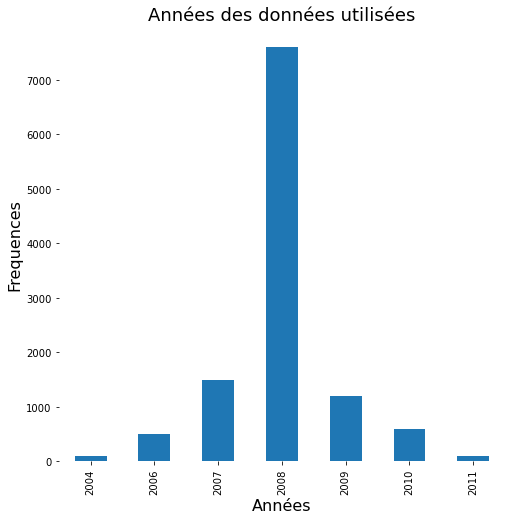

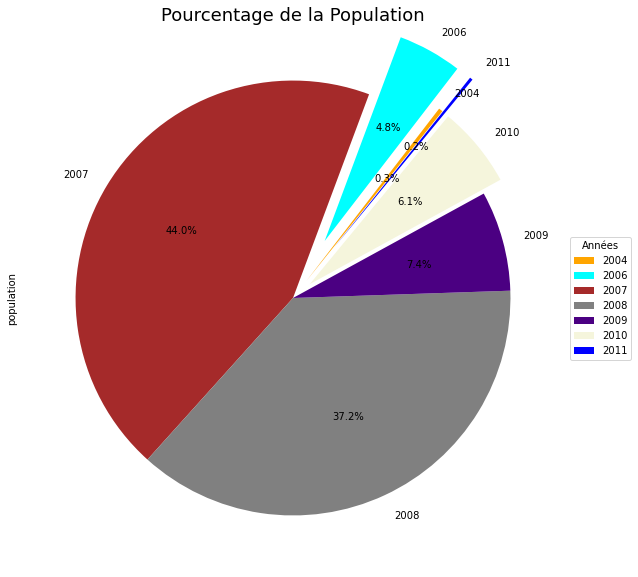

In [11]:
#list_annee = np.sort(df_final['year'].unique())
list_pays = (len(df_final['country'].unique()))
list_popul = df_final.groupby('year', as_index=False).sum().population
# Population par année
popu_total = df_popu.groupby('year', as_index=False).sum().population
popu_pourcen = list_popul/popu_total
#print(f"Années des donnés utilisées : {list_annee}")
#print('#'*40)
print(f"Nombre des pays presents : {list_pays} pays")
print('#'*40)
#print(f"Population mondial en pourcentage : {list_popul/popu_total}")
#print('#'*40)
print(f"{round(list_popul.sum() / popu_total.mean(), 0)} % de la population est couvert")
# Plotting 
fig, ax = plt.subplots(figsize=(8,8))
df_final.year.value_counts().sort_index().plot(kind='bar', ax=ax)
ax.set_title("Années des données utilisées", fontsize=18)
ax.set_xlabel("Années", fontsize=16)
ax.set_ylabel("Frequences", fontsize=16)
ax = plt.gca()
for spine in plt.gca().spines.values():
    spine.set_visible(False)
#plt.savefig("pays.jpg", dpi=1200)
plt.show()

fig, ax = plt.subplots(figsize=(10.5, 6))
ax.set_title("Pourcentage de la Population", fontsize=18)
colors = ( "orange", "cyan", "brown", "grey", "indigo", "beige", 'blue')
labels = ['2004', '2006', '2007', '2008', '2009', '2010', '2011']
ratios = [.27, .56, .17]
explode = [.1, 0.3, 0, 0, 0, 0.1, 0.3]
angle = 190 * ratios[0]
popu_pourcen.plot(kind='pie', autopct='%1.1f%%',labels=labels,  explode=explode, startangle=angle, colors=colors,figsize=(10, 10))
# Adding legend
ax.legend( labels,
          title ="Années",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))
#plt.savefig("%_popu.jpg", dpi=1200)
plt.show()

In [12]:
df_final['nb_quantiles'].unique() # Type de quantile

array([100], dtype=int64)

- **Ce sont que centiles**
- **Les centiles permet de réduire la taille de l'echantillon, en préservant suffisamment d'information pour faire l'analye.**

***Unité PPP et Méthode Eltöte-Köves-Szulc.***

L'unité de mesure utilisée est la Parité de Pouvoir d'Achat (PPA = PPP) en $. C'est un taux de conversion monaitaire qui égalise les pouvoirs d'achats des différentes monaies. Une somme d'argent donnée convertie au moyen des PPP permettra d'acheter le même panier de biens et de services dans les différents pays (environ 2500 biens et services entrent dans la composition de ce panier).

La méthode Eltöte-Köves-Szulc (EKS) est une méthode d'agrégation. Sa particularité est d'intégrer 2 niveaux d'agrégations :

- l'agrégation au niveau élémentaire aboutissant à des PPP élémentaires non pondérées (parités binaires entre les pays);
- l'agrégation au niveau global donnant lieu à des PPP pondérées par les dépenses du PIB.

## <center> Mission 2 </center>

- Montrez la diversité des pays en termes de distribution de revenus à l'aide d'un graphique. Celui-ci représentera le revenu moyen (axe des ordonnées, sur une échelle logarithmique) de chacune des classes de revenus (axe des abscisses) pour 5 à 10 pays que vous aurez choisis pour montrer la diversité des cas.
- Représentez la courbe de Lorenz de chacun des pays choisis.
- Pour chacun de ces pays, représentez l'évolution de l'indice de Gini au fil des ans.
- Classez les pays par indice de Gini. Donnez la moyenne, les 5 pays ayant l'indice de Gini le plus élevé et les 5 pays ayant l'indice de Gini le plus faible. En quelle position se trouve la France ?

In [13]:
# On va utiliser K-means pour reagrouper les pays
df_cluster = df_final.copy()
df_cluster.drop_duplicates(subset=['country'], inplace=True)
# On elimine le pays Fiji pour pas fauser l'analyse parce qu'il a un gdpppp très élevé
#df_cluster = df_cluster[df_cluster['country'] != 'FJI']

## On va remplacer le valeur aberrant du Fiji 'gdpppp' 4300332.0 
## Après verification sur internet le gdpppp du Fiji pour l'année 2008 été de : 4 167,69
df_cluster['gdpppp'].replace({4300332: 4167.60}, inplace=True)

col_names = ['gini', 'gdpppp', 'income']

features = df_cluster[col_names] 
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features = pd.DataFrame(features, columns = col_names)
scaled_features.head()

,gini,gdpppp,income
0,-0.881155,-0.390309,-0.019627
1,0.798154,0.061547,-0.455846
2,-1.328970,-0.518932,-0.352463
3,-1.105063,1.814120,2.028375
4,-0.769201,-0.328974,-0.324054


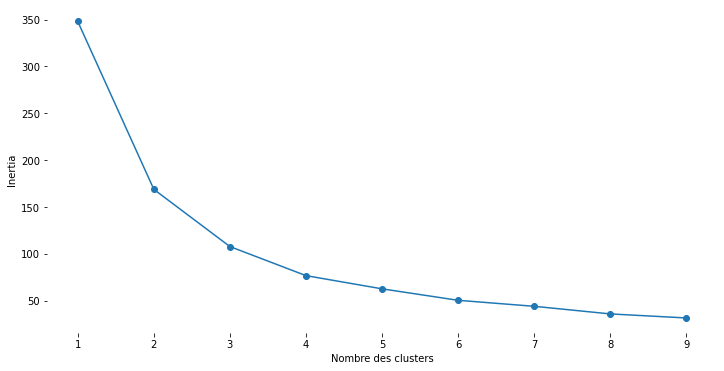

In [14]:
## Clustering model
SSE = []
for cluster in range(1, 10):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init="k-means++")
    kmeans.fit(scaled_features)
    SSE.append(kmeans.inertia_)
    
frame = pd.DataFrame({'Cluster':range(1, 10), 'SSE': SSE})
plt.figure(figsize=(12, 6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Nombre des clusters')
plt.ylabel('Inertia')
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
#plt.savefig("kmeans.jpg", dpi=1200)
plt.show()

In [15]:
# Silhoutte score
kmeans = KMeans(n_jobs = -1, n_clusters = 4, init='k-means++')
kmeans.fit(scaled_features)
print(silhouette_score(scaled_features, kmeans.labels_, metric='euclidean'))

0.42694609204963946


In [16]:
# Model KMeans
model = KMeans(n_clusters=4)
clusters = model.fit_predict(scaled_features.iloc[:,:2])
scaled_features['label'] = clusters
# Prediction
pred = model.predict(scaled_features.iloc[:,:2])
frame = pd.DataFrame(df_cluster)
frame['cluster'] = pred
frame.head(2)

,country,year,quantile,nb_quantiles,income,gdpppp,population,gini,IGEincome,cluster
0,ALB,2008,1,100,728.89795,7297.0,2947314.0,0.30,0.8,1
100,ARG,2008,1,100,254.08942,13220.0,40080159.0,0.45,0.9,0


In [17]:
#Taille des 4 clusters
print(str(len(df_cluster[df_cluster['cluster'] == 0])) + " Nombre des clusters dans la première Echantillon")
print(str(len(df_cluster[df_cluster['cluster'] == 1])) + " Nombre des clusters dans la seconde Echantillon")
print(str(len(df_cluster[df_cluster['cluster'] == 2])) + " Nombre des clusters dans la troisième Echantillon")
print(str(len(df_cluster[df_cluster['cluster'] == 3])) + " Nombre des clusters dans la quatrième Echantillon")

37 Nombre des clusters dans la première Echantillon
38 Nombre des clusters dans la seconde Echantillon
26 Nombre des clusters dans la troisième Echantillon
15 Nombre des clusters dans la quatrième Echantillon


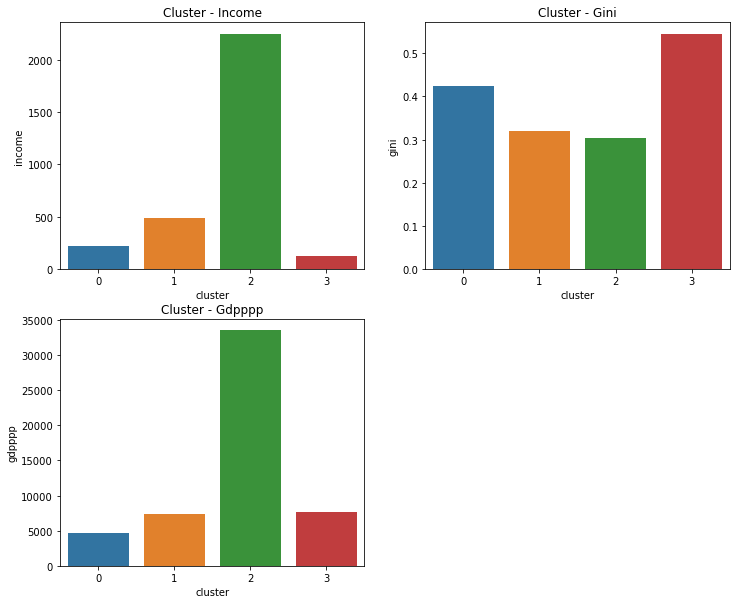

In [18]:
# Analyse des clusters
avg_df = df_cluster.groupby(['cluster'], as_index=False).mean()

# Graphiques des clusters
plt.figure(figsize=(12,10))
plt.subplot(221)
plt.title('Cluster - Income')
sns.barplot(x='cluster', y='income', data=avg_df);

plt.subplot(222)
plt.title('Cluster - Gini')
sns.barplot(x='cluster', y='gini', data=avg_df);

plt.subplot(223)
plt.title('Cluster - Gdpppp')
sns.barplot(x='cluster', y='gdpppp', data=avg_df);
#plt.savefig("gdpp.jpg", dpi=1200)
plt.show()

**Observation:**
- Le cluster 0 est celui qui a un **GDPppp** et l'**Income** plus élevé.


> ###  Diversité des pays en termes de distribution de revenus

In [19]:
n_clusters = 4
X = df_cluster.gdpppp.values.reshape(-1, 1)
X = df_cluster[['gdpppp', 'population']].values.reshape(-1, 1)

# Normalisation des données
pays = preprocessing.scale(X)
# Clustering avec la méthode des kmeans
km = KMeans(n_clusters = n_clusters).fit(X)
# On determine les pays qui sont les plus proches des centroïdes des clusters
pays_plus_proches, _ = pairwise_distances_argmin_min(km.cluster_centers_, X)
pays_cluster = df_cluster.iloc[pays_plus_proches].sort_values('gdpppp', ascending=False)
pays_cluster

,country,year,quantile,nb_quantiles,income,gdpppp,population,gini,IGEincome,cluster
2500,DNK,2008,1,100,1960.654000,34130.0,5493621.0,0.26,0.1,2
7099,MNE,2008,1,100,1344.219500,10556.0,616969.0,0.29,0.5,1
3500,GEO,2008,1,100,97.541626,4516.0,3848449.0,0.39,0.5,0
10099,TJK,2009,1,100,436.139860,1761.0,7364752.0,0.31,0.5,1


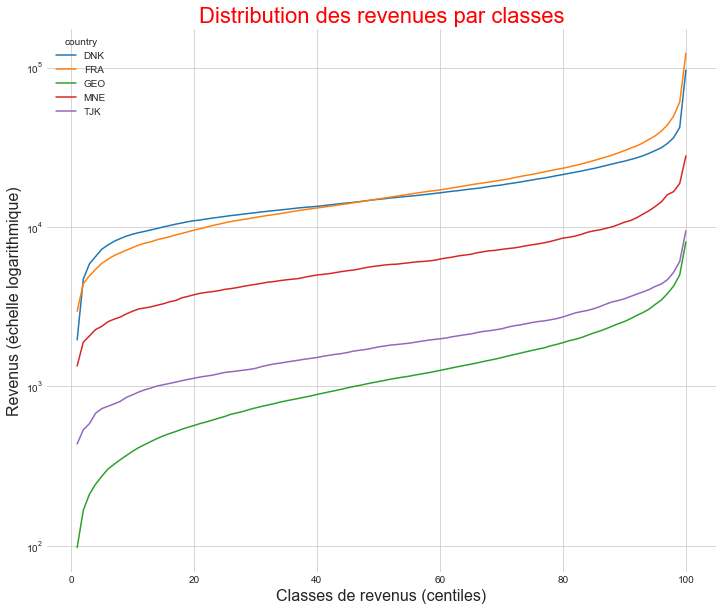

In [20]:
# Graphique pour les revenus de differents pays
liste_pays = ['DNK', 'MNE', 'GEO', 'TJK', 'FRA']
df_pays = df_final[df_final.country.isin(liste_pays) == True]
# Plot
fig = plt.figure(figsize=(12, 10))
plt.style.use('seaborn-whitegrid')
sns.lineplot(data=df_pays, x = 'quantile', y='income', hue='country')
plt.yscale('log')
plt.title('Distribution des revenues par classes', size=22, color='red')
plt.xlabel('Classes de revenus (centiles)', size=16)
plt.ylabel('Revenus (échelle logarithmique)', size=16)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
#plt.savefig("dist_revenu.jpg", dpi=1200)
plt.show()

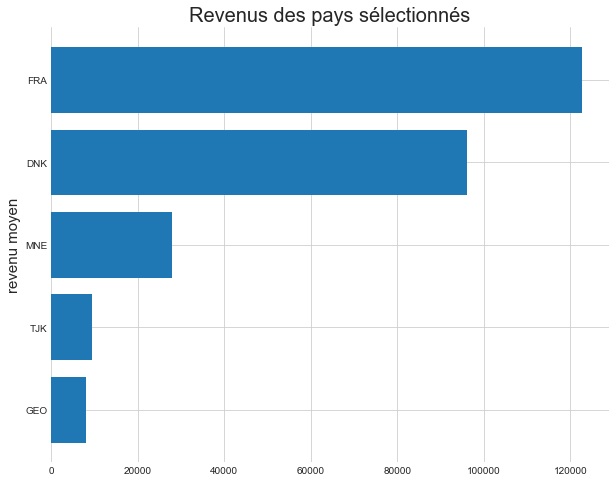

In [21]:
# Graphique pour le revenu 
incomes_pays = df_final[(df_final['country'] == 'FRA') |
                     (df_final['country'] == 'DNK') |
                     (df_final['country'] == 'MNE') |
                     (df_final['country'] == 'GEO') |
                     (df_final['country'] == 'TJK')].sort_values('income')

plt.figure(figsize=(10,8))

plt.barh(incomes_pays.country, incomes_pays.income)

plt.title('Revenus des pays sélectionnés', size=20)
plt.ylabel("revenu moyen", size=15)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
#plt.savefig("revenus_moyens.jpg", dpi=1200)
plt.show()

**Observation:**
- On remarque un edifference en la distribution de revenu entre pays représenté. Denmark et France ont le revenu plus élevé.

> ### Représentez la courbe de Lorenz de chacun des pays choisis.

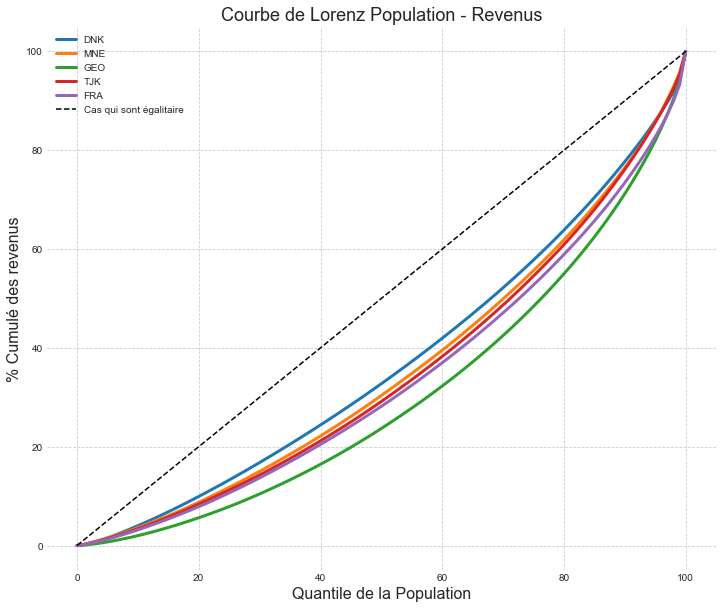

In [22]:
# Graphique Courbe de Lorenz
plt.figure(figsize=(12, 10))
gini_liste = []

for count in liste_pays:
    revenu_pays = df_final[df_final.country == count]['income'].sum()
    
    income_pays = df_final[df_final.country == count]['income'].values
    n = len(income_pays)
    
    # Lorenz Courbe
    lorenz = (np.cumsum(np.sort(df_final[df_final.country == count]['income'])) / revenu_pays) * 100
    lorenz = np.append([0], lorenz)
    x = np.append([0], df_final[df_final.country == count]['quantile'])
    plt.plot(x, lorenz, linewidth=3, label=count)
    
plt.plot([0, 100], [0, 100], 'black', linestyle = '--', linewidth=1.5, label='Cas qui sont égalitaire')
plt.xlabel('Quantile de la Population', size=16)
plt.ylabel('% Cumulé des revenus', size=16)
plt.legend(loc='best', fontsize=10)
plt.grid(True, linestyle='--')
plt.title('Courbe de Lorenz Population - Revenus', size = 18)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
#plt.savefig("courbe_lorenz.jpg", dpi=1200)
plt.show()

> ### Évolution de l'indice de Gini au fil des ans

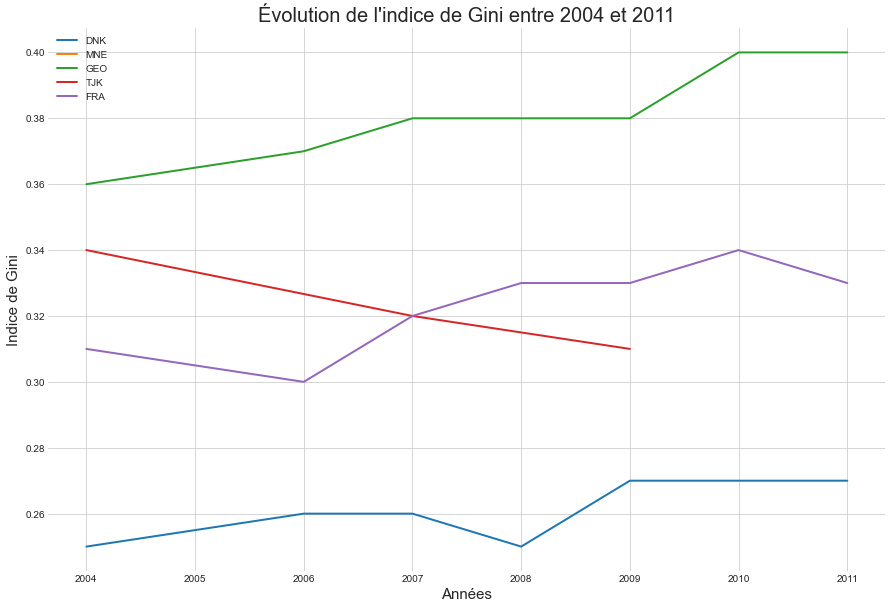

In [23]:
liste_pays = ['DNK', 'MNE', 'GEO', 'TJK', 'FRA']

#Évolution de l'indice de Gini
plt.figure(figsize=(15,10))

for c_code  in liste_pays:   
    plt.plot(df_gini[df_gini['country'] == c_code]['year'],
             df_gini[df_gini.country == c_code]['gini'], linewidth=2, label = c_code)

plt.title("Évolution de l'indice de Gini entre 2004 et 2011", fontsize=20)
plt.xlabel("Années", fontsize=15)
plt.ylabel("Indice de Gini", fontsize=15)
plt.legend()

plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
#plt.savefig("gini.jpg", dpi=1200)
plt.show()

**Observation :**
- On observe que l'indice de gini pour la Gorgia est plus élevé.
- Denmark a l'indice de gini moins important.

> ### Classez les pays par indice de Gini
- Donnez la moyenne, les 5 pays ayant l'indice de Gini le plus élevé ;
- Les 5 pays ayant l'indice de Gini le plus faible ;
- En quelle position se trouve la France. 

In [24]:
# On va ulitice la function rank de pandas pour obtenir l'information
ranking_gini = pd.DataFrame(df_gini.groupby('country').gini.mean()).reset_index()
ranking_gini['Rank'] = ranking_gini['gini'].rank(ascending=True)

# 5 pays avec l'indice de gini le plus élevé
gini_eleve = ranking_gini.sort_values(by='gini', ascending=False).head()
# 5 pays avec l'indice de gini le plus faible
gini_faible = ranking_gini.sort_values(by='gini', ascending=True).head()
# gini France
gini_france = ranking_gini[ranking_gini.country == 'FRA']

print('Indice de Gini Élevé :')
display(gini_eleve)
print('Indice de Gini Faible :')
display(gini_faible)
print('Position de la France :')
display(gini_france)

Indice de Gini Élevé :


,country,gini,Rank
140,ZAF,0.63,143.0
92,NAM,0.61,142.0
18,BWA,0.60,141.0
29,COM,0.56,139.5
19,CAF,0.56,139.5


Indice de Gini Faible :


,country,gini,Rank
118,SVN,0.245714,1.0
35,DNK,0.261429,2.0
117,SVK,0.262857,3.0
33,CZE,0.265714,4.0
132,UKR,0.268571,5.0


Position de la France :


,country,gini,Rank
45,FRA,0.322857,35.0


**Observation :**
- Les pays avec l'indice de gini le plus élevé sont ;
-- ***L'Afrique du Sud, Namibia, Botswana, Comoros et République de l'Afrique Centrale***
- Les pays avel l'indice de gini le plus faible sont ;
-- ***Slovenia, Denmarque, République Slovaque, Republique Chech et Ukrania***
- La France se situe à la 35ème position.

## <center> Mission 3 </center>

In [25]:
show_n_missing(df_final, 'IGEincome')

XKX - 100
SYR - 100


['XKX', 'SYR']

In [26]:
# On a 2 pays avec le valeur manquent pour 'IGEincome'
# Kosovo est un pays d'Europe du Sud / IGEincome 0.4
# Syria est un pays de l'Asie de l'Ouest / IGEincome 0.5

missing = show_n_missing(df_final, 'IGEincome')
for country in missing:
    if list(df_final[df_final.country == 'XKX']):
        df_final.loc[df_final.country == country, 'IGEincome'] = .4
    else:
        df_final.loc[df_final.country == country, 'IGEincome'] = .5

XKX - 100
SYR - 100


- 1 - ***Générez un grand nombre \(n\) de réalisations d'une variable que nous appellerons   $ln(Y_{parent})$ selon une loi normale. Le choix de la moyenne et de l'écart type n'auront pas d'incidence sur le résultat final. \(n\) doit être supérieur à 1000 fois le nombre de quantiles.***

In [27]:
# n corresponde à 1000 * nb_quantiles
ln_y_parent = st.norm(0,1).rvs(size=n)


- 2 - ***Générez \(n\) réalisations du terme d'erreur \(\epsilon\) selon une loi normale de moyenne 0 et d'écart type 1.***

In [28]:
# Pour generer selon une loi normale de moyenne 0 et d'ecart type 1
residues = st.norm(0,1).rvs(size=n)

- 3 - ***Pour une valeur donnée de $p_j$  (par exemple 0.9), calculez $y_{child} = e^{\alpha+p_jln(y_{parent})+\epsilon}$   . Le choix de  $ \alpha$ n'a aucune incidence sur le résultat final et peut être supprimé. À ce stade, $y_{child}$ contient des valeurs dont l'ordre de grandeur ne reflète pas la réalité, mais cela n'a pas d'influence pour la suite.***

In [29]:
pj = 0.9
nb_quantiles = 10
n = 1000 * nb_quantiles

#y_child = np.exp(pj*ln_y_parent + residues), np.exp(ln_y_parent)
y_child, y_parents = generate_incomes(n, pj)

- 4 - ***Pour chacun des \(n\) individus générés, calculez la classe de revenu $c_{i_child}$ ainsi que la classe de revenu de ses parents $c_{i,parent}$ , à partir de $y_{child}$ et  $y_{parent}$.***

In [30]:
sample = compute_quantiles(y_child, y_parents, nb_quantiles)
sample.head(2)

,y_child,y_parents,c_i_child,c_i_parent
0,0.172536,0.703433,1,4
1,24.922193,9.767340,10,10


- 5 - ***À partir de cette dernière information, estimez pour chaque  $(c_{i,child})$ la distribution conditionnelle de $(c_{i,parent})$ . Par exemple, si vous observez 6 individus ayant à la fois  $(c_{i,child} = 5)$ et $(c_{i,parent} = 8)$ , et que 200 individus sur 20000 ont $( c_{i,child} = 5)$ , alors la probabilité d'avoir $( c_{i,parent} = 8)$ sachant  $(c_{i,child} = 5)$ et sachant $(\rho_j=0.9)$ sera estimée à 6/200 (On note cette probabilité comme ceci : $(P(c_{i,parent}=8|c_{i,child}=5,\rho_j=0.9) = 0.03))$. Si votre population est divisée en $(c)$ classes de revenu, vous devriez alors avoir $(c^2)$ estimations de ces probabilités conditionnelles, pour chaque pays.***

In [31]:
cd = conditional_distributions(sample, nb_quantiles)

- 6 - ***Optionnellement et pour vérifier la cohérence de votre code, vous pouvez créer un graphique représentant ces distributions conditionnelles. Voici 2 exemples pour une population segmentée en 10 classes, pour 2 valeurs de $(rho_j)$ : l'une traduisant une forte mobilité (0.1) et l'autre une très faible mobilité (0.9)***

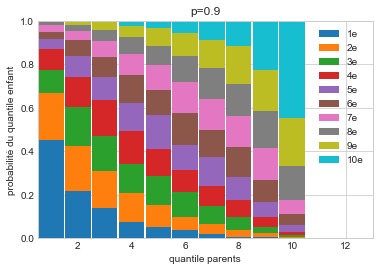

In [32]:
# Faible movilité (pj=0.9)
plot_conditional_distributions(0.9, cd, nb_quantiles)

- 7 - ***Éventuellement et pour éviter toute confusion, effacez les individus que vous venez de générer (nous n'en avons plus besoin), et ne gardez que les distributions conditionnelles.***

In [33]:
del y_parents, y_child

- 8 - ***Nous allons maintenant travailler sur un nouvel échantillon. Celui-ci sera créé à partir de la WID. Pour chaque individu de la World Income Distribution, créez-en 499 "clones". La taille de votre nouvel échantillon sera donc 500 fois plus grand que celui de la World Income Distribution.***

In [34]:
new_echantillon = df_final.copy()

# On créé 499 copies de chaques enfants
new_sample = new_echantillon.append([new_echantillon]*499, ignore_index=True)
new_sample['c_i_parent'] = 0

new_echantillon2 = new_sample.copy()
dist_pays = new_echantillon2[['country', 'quantile', 'income', 'IGEincome', 
                        'c_i_parent', 'gini']]
# Renomme
dist_pays.columns = ['country', 'c_i_child', 'income_child', 
                     'coeff_elasticite', 'c_i_parent', 'G_j'] 

distrib_pays = dist_pays.copy()
distrib_pays.head()

,country,c_i_child,income_child,coeff_elasticite,c_i_parent,G_j
0,ALB,1,728.89795,0.8,0,0.3
1,ALB,2,916.66235,0.8,0,0.3
2,ALB,3,1010.91600,0.8,0,0.3
3,ALB,4,1086.90780,0.8,0,0.3
4,ALB,5,1132.69970,0.8,0,0.3


- 9 - ***Pour chaque \(c_{i,child}\) et chaque pays, il y a maintenant 500 individus. Vous attribuerez aux 500 individus leurs classes \( c_{i,parent}\) conformément aux distributions trouvées précédemment. Par exemple, si \(P(c_{i,parent}=8|c_{i,child}=5,\rho_j=0.9) = 0.03\) , alors vous assignerez la classe \(c_{i,parent} = 8\) à 15 des 500 individus du pays \( j\) ayant \(c_{i,child}=5\) , car 500*0.03 = 15.**

In [35]:
nb_quantiles = 100       # nombre de quantiles (nombre de classes de revenu)
n  = len(distrib_pays) # taille de l'échantillon
ln_y_parent = st.norm(0,1).rvs(size=n)
residus = st.norm(0,1).rvs(size=n)

d_pays = pd.concat([pd.DataFrame(list(zip(ln_y_parent, residus)), columns=['ln_y_parent','residus']), 
                    distrib_pays], axis=1)

def generate_y_child(n, pj):
    return np.exp(pj * ln_y_parent + residus)

def generate_y_parents(n, pj):
    return np.exp(ln_y_parent)

d_pays['y_child'] = 0
d_pays['y_child'] = generate_y_child(n, distrib_pays['coeff_elasticite'])
d_pays['y_parents'] = 0
d_pays['y_parents'] = generate_y_parents(n, distrib_pays['coeff_elasticite'])

d_pays['c_i_child'] = pd.qcut(d_pays['y_child'], 100, labels=False) 
d_pays['c_i_parent'] = pd.qcut(d_pays['y_parents'], 100, labels=False) 


d_pays.head()

,ln_y_parent,residus,country,c_i_child,income_child,coeff_elasticite,c_i_parent,G_j,y_child,y_parents
0,-0.380232,-1.064643,ALB,11,728.89795,0.8,35,0.3,0.254405,0.683703
1,0.398350,-0.348634,ALB,49,916.66235,0.8,65,0.3,0.970490,1.489365
2,0.398443,-1.447134,ALB,16,1010.91600,0.8,65,0.3,0.323557,1.489503
3,-0.093410,-0.619369,ALB,27,1086.90780,0.8,46,0.3,0.499525,0.910820
4,0.067341,-2.390245,ALB,2,1132.69970,0.8,52,0.3,0.096678,1.069660


- 10 - ***Éventuellement et pour éviter toute confusion, effacez la variable \(c_{i,child}\)  : nous n'en avons pas besoin pour la mission 4.***


In [36]:
# Suppression de la variable c_i_child inutile pour la mission 4
d_pays.drop(columns='c_i_child', inplace=True)

- 11 - ***Assurez-vous que votre nouvel échantillon contiennent bien les variables initialement présentes dans la World Income Distribution : \(m_j\) et \(G_j\) .***

In [37]:
# Creation df avec le revenu moyen (m_j)
y_child_moyen_df = d_pays.groupby(by='country').mean()
y_child_moyen_df.reset_index(inplace=True)
y_child_moyen_df = y_child_moyen_df[['country', 'income_child']]
y_child_moyen_df.rename(columns={'income_child': 'm_j'}, inplace=True)

# Ajout de la colonne y_child_moyen_df
df_wid_500 = pd.merge(d_pays, y_child_moyen_df, on='country')
# Ajout des colonnes 'logarithmes'
df_wid_500['log_income_child'] = np.log(df_wid_500['income_child'])
df_wid_500['log_m_j'] = np.log(df_wid_500['m_j'])
df_wid_500.head(2)

,ln_y_parent,residus,country,income_child,coeff_elasticite,c_i_parent,G_j,y_child,y_parents,m_j,log_income_child,log_m_j
0,-0.380232,-1.064643,ALB,728.89795,0.8,35,0.3,0.254405,0.683703,2994.829902,6.591534,8.004643
1,0.398350,-0.348634,ALB,916.66235,0.8,65,0.3,0.970490,1.489365,2994.829902,6.820739,8.004643


## <center> Mission 4 </center>

Pour cette mission 4, nous chercherons à expliquer le revenu des individus en fonction de plusieurs variables explicatives : le pays de l'individu, l'indice de Gini de ce pays, la classe de revenus des parents, etc.

Appliquez une ANOVA sur vos données, en n’incluant comme variable explicative que le pays de l’individu. Analysez la performance du modèle.

***Pour chacune des régressions suivantes, vous testerez 2 version : l'une en exprimant le revenu moyen du pays et les revenus (parents & enfants) en logarithme (ln), l'autre en les laissant tels quels. Vous choisirez la version la plus performante pour répondre aux question.***

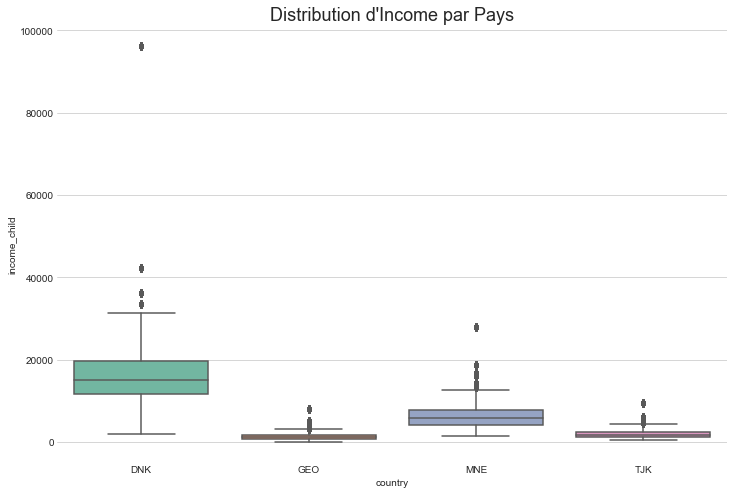

In [38]:
# On va etudier les mêmes 5 pays de la mission 2 
pays_anova = ['DNK', 'MNE', 'GEO', 'TJK']
fig = plt.figure(figsize=(12, 8), constrained_layout=False)
ax = sns.boxplot(x='country', y='income_child', data=df_wid_500[df_wid_500.country.isin(pays_anova)], palette='Set2')
ax.set_title('Distribution d\'Income par Pays', fontsize=18)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
#plt.savefig("d_in_pays.jpg", dpi=1200)
plt.show()

**Observation :**
- Les pays semblent très different, avec un ecarts très important ente eux.

> ### Verification hypothèse de normalité

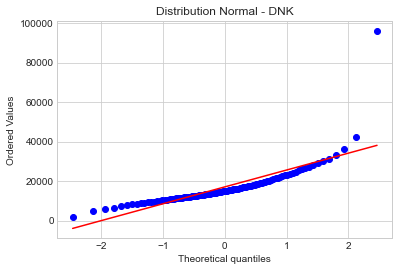

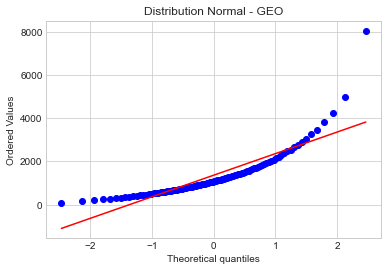

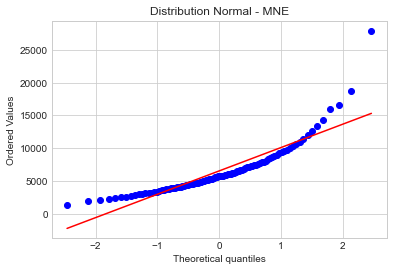

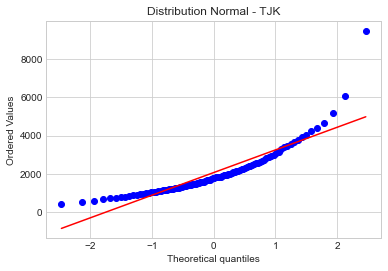

In [39]:
anova_test_pays = df_wid_500[df_wid_500.country.isin(pays_anova) == True]

anova_test = anova_test_pays[['country', 'income_child']].drop_duplicates()
pays_income = anova_test_pays['country'].unique()
for pays in pays_income:
    stats.probplot(anova_test[anova_test['country'] == pays]['income_child'], dist='norm', plot=plt)
    plt.title('Distribution Normal - ' + pays)
    #plt.savefig("dnk.jpg")
    plt.show()

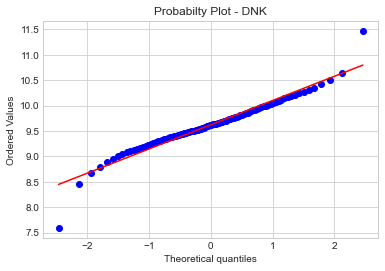

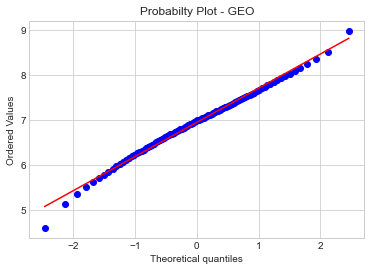

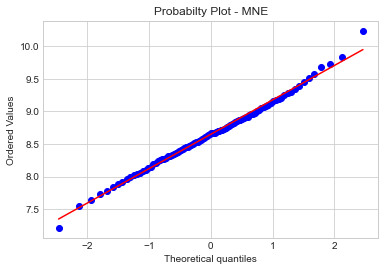

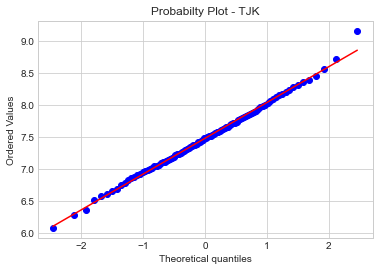

In [40]:
anova_test_log = anova_test_pays[['country','log_income_child']].drop_duplicates()
pays_income = anova_test['country'].unique()
for pay in pays_income:
    stats.probplot(anova_test_log[anova_test_log['country'] == pay]['log_income_child'], dist='norm', plot=plt)
    plt.title('Probabilty Plot - ' + pay)
    #plt.savefig("log_tjk.jpg")
    plt.show()

> ### Anova Test 1

Hypothèses :
- $H_0$ : Le pays d'origine n'a aucune influence sur le revenu de l'individu.
- $H_1$ : Le pays d'origine influence le revenu de l'individu.

In [41]:
# Creation ANOVA backbone table
data = [['Between Groups', '', '', '', '', '', ''], ['Within Groups', '', '', '', '', '', ''], ['Total', '', '', '', '', '', '']]
anova_table = pd.DataFrame(data, columns = ['Source of Variation', 'SS', 'df', 'MS', 'F', 'P-value', 'F crit'])
anova_table.set_index('Source of Variation', inplace=True)

# Calculate SSTR and update anova table
x_bar = df_wid_500['income_child'].mean()
SSTR = df_wid_500.groupby('country').count() * (df_wid_500.groupby('country').mean() - x_bar)**2
anova_table['SS']['Between Groups'] = SSTR['income_child'].sum()

# Calculate SSe and update anova table
SSE = (df_wid_500.groupby('country').count() - 1) * df_wid_500.groupby('country').std()**2
anova_table['SS']['Within Groups'] = SSE['income_child'].sum()

# Calculate SSTR and update anova table
SSTR = SSTR['income_child'].sum() + SSE['income_child'].sum()
anova_table['SS']['Total'] = SSTR

# Update degree of freedom
anova_table['df']['Between Groups'] = df_wid_500['country'].nunique() - 1
anova_table['df']['Within Groups'] = df_wid_500.shape[0] - df_wid_500['country'].nunique()
anova_table['df']['Total'] = df_wid_500.shape[0] - 1

# Calculate MS
anova_table['MS'] = anova_table['SS'] / anova_table['df']

# Calculate F
F = anova_table['MS']['Between Groups'] / anova_table['MS']['Within Groups']
anova_table['F']['Between Groups'] = F

# P-value
anova_table['P-value']['Between Groups'] = 1 - stats.f.cdf(F, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])


# F critical
alpha = 0.05
# Pssible types 'right-tailed, left-tailed, two-tailed'
tail_hypothesis_type = 'two-tailed'
if tail_hypothesis_type == 'two-tailes':
    alpha /= 2
anova_table['F crit']['Between Groups'] = stats.f.ppf(1-alpha, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# Final anova table
anova_table

,SS,df,MS,F,P-value,F crit
Source of Variation,,,,,,
Between Groups,2.55119e+14,115,2.21842e+12,49710.8,1.11022e-16,1.22635
Within Groups,2.58829e+14,5799884,4.46266e+07,,,
Total,5.13948e+14,5799999,8.86118e+07,,,


In [42]:
# The p-value approach
print('Approach 1: The p-value approach to hypothesis testing in the decision rule')
conclusion = 'Failed to reject the null hypothesis.'
if anova_table['P-value']['Between Groups'] <= alpha:
    conclusion = 'Null Hypothesis is rejected.'
print('F-score is:', anova_table['F']['Between Groups'], ' and p value is:', anova_table['P-value']['Between Groups'])
print(conclusion)

# The critical value approach
print('\n-------------------------------------------------------------------------------')
print('Approach 2: The critical value approach to hypothesis testing is the decision rule')
conclusion = 'Failed to reject the null hypothesis.'
if anova_table['F']['Between Groups'] > anova_table['F crit']['Between Groups']:
    conclusion = 'Null Hypothesis is rejected.'
print('F-score is:', anova_table['F']['Between Groups'], ' and critical value is:', anova_table['F crit']['Between Groups'])
print(conclusion)
print('\n--------------------------------------------------------------------------------')
print('La variance est de :', anova_table['SS']['Between Groups'] / anova_table['SS']['Total'].sum().sum())

Approach 1: The p-value approach to hypothesis testing in the decision rule
F-score is: 49710.75888954381  and p value is: 1.1102230246251565e-16
Null Hypothesis is rejected.

-------------------------------------------------------------------------------
Approach 2: The critical value approach to hypothesis testing is the decision rule
F-score is: 49710.75888954381  and critical value is: 1.2263482172571272
Null Hypothesis is rejected.

--------------------------------------------------------------------------------
La variance est de : 0.496390142310989


**Observation :**
- On puet conclure que les pays ont une influence sur le revenue moyenne des individus avec un **P-value inférieure à 5%.**
- On peut conclure que la variable **Pays explique près de 50% de la variance du revenu de l'individu.** La moitié de la variance sur le revenu est expliquée par d'autres factuers non considérés dans le modèle.

> ### Anova Test 2

In [43]:
# Calcul et intégration de la variable logarithmique 'ln_income'
df_wid_500['ln_income'] = np.log(df_wid_500['log_income_child'])

# Create ANOVA backbone table
data = [['Between Groups', '', '', '', '', '', ''], ['Within Groups', '', '', '', '', '', ''], ['Total', '', '', '', '', '', '']] 
anova_table = pd.DataFrame(data, columns = ['Source of Variation', 'SS', 'df', 'MS', 'F', 'P-value', 'F crit']) 
anova_table.set_index('Source of Variation', inplace = True)

# calculate SSTR and update anova table
x_bar = df_wid_500['log_income_child'].mean()
SSTR = df_wid_500.groupby('country').count() * (df_wid_500.groupby('country').mean() - x_bar)**2
anova_table['SS']['Between Groups'] = SSTR['log_income_child'].sum()

# calculate SSE and update anova table
SSE = (df_wid_500.groupby('country').count() - 1) * df_wid_500.groupby('country').std()**2
anova_table['SS']['Within Groups'] = SSE['log_income_child'].sum()

# calculate SSTR and update anova table
SSTR = SSTR['log_income_child'].sum() + SSE['log_income_child'].sum()
anova_table['SS']['Total'] = SSTR

# update degree of freedom
anova_table['df']['Between Groups'] = df_wid_500['country'].nunique() - 1
anova_table['df']['Within Groups'] = df_wid_500.shape[0] - df_wid_500['country'].nunique()
anova_table['df']['Total'] = df_wid_500.shape[0] - 1

# calculate MS
anova_table['MS'] = anova_table['SS'] / anova_table['df']

# calculate F 
F = anova_table['MS']['Between Groups'] / anova_table['MS']['Within Groups']
anova_table['F']['Between Groups'] = F

# p-value
anova_table['P-value']['Between Groups'] = 1 - stats.f.cdf(F, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# F critical 
alpha = 0.05
# possible types "right-tailed, left-tailed, two-tailed"
tail_hypothesis_type = "two-tailed"
if tail_hypothesis_type == "two-tailed":
    alpha /= 2
anova_table['F crit']['Between Groups'] = stats.f.ppf(1-alpha, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# Final ANOVA Table
anova_table

,SS,df,MS,F,P-value,F crit
Source of Variation,,,,,,
Between Groups,8.06721e+06,115,70149.6,135832,1.11022e-16,1.27453
Within Groups,2.99531e+06,5799884,0.516443,,,
Total,1.10625e+07,5799999,1.90733,,,


In [44]:
# The p-value approach
print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
conclusion = "Failed to reject the null hypothesis."
if anova_table['P-value']['Between Groups'] <= alpha:
    conclusion = "Null Hypothesis is rejected."
print("F-score is:", anova_table['F']['Between Groups'], " and p value is:", anova_table['P-value']['Between Groups'])    
print(conclusion)
    
# The critical value approach
print("\n--------------------------------------------------------------------------------------")
print("Approach 2: The critical value approach to hypothesis testing in the decision rule")
conclusion = "Failed to reject the null hypothesis."
if anova_table['F']['Between Groups'] > anova_table['F crit']['Between Groups']:
    conclusion = "Null Hypothesis is rejected."
print("F-score is:", anova_table['F']['Between Groups'], " and critical value is:", anova_table['F crit']['Between Groups'])
print(conclusion)
print('\n--------------------------------------------------------------------------------')
print('La variance est de :', anova_table['SS']['Between Groups'] / anova_table['SS']['Total'].sum().sum())

Approach 1: The p-value approach to hypothesis testing in the decision rule
F-score is: 135832.37396814028  and p value is: 1.1102230246251565e-16
Null Hypothesis is rejected.

--------------------------------------------------------------------------------------
Approach 2: The critical value approach to hypothesis testing in the decision rule
F-score is: 135832.37396814028  and critical value is: 1.2745345732101279
Null Hypothesis is rejected.

--------------------------------------------------------------------------------
La variance est de : 0.7292381117731904


**Observation :**
- En considérant le logarithme du revenu, la variance expliquée est plus concluante, **73% contre 50% précédemment.**

> ### Regression Linéaire

Appliquez une régression linéaire sur vos données, en incluant comme variables explicatives uniquement le revenu moyen du pays de l’individu et l’indice de Gini du pays de l’individu. Quel est le pourcentage de variance expliquée par votre modèle ?

Selon ce modèle, donnez la décomposition de variance totale expliquée par :

- le pays de naissance (ie. le revenu moyen et l’indice de Gini) ;
- les autres facteurs non considérés dans le modèle (efforts, chance, etc.).

Améliorez le modèle précédent en incluant maintenant la classe de revenu des parents. Quel est le pourcentage de variance expliquée par ce nouveau modèle ?

- **Première Régression Linéaire : Revenu moyen du pays de l’individu et l’indice de Gini du pays de l’individu**

Hypothèses :

- $H0$: le paramètre de la variable n'est pas significatif.
- $H1$: le paramètre de la variable est significatif.

In [45]:
alpha = 0.05
RL1 = smf.ols('income_child ~ m_j + G_j', data=df_wid_500).fit(alpha=alpha) 
print(RL1.summary())

                            OLS Regression Results                            
Dep. Variable:           income_child   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                 2.858e+06
Date:                Tue, 28 Dec 2021   Prob (F-statistic):               0.00
Time:                        15:38:21   Log-Likelihood:            -5.9310e+07
No. Observations:             5800000   AIC:                         1.186e+08
Df Residuals:                 5799997   BIC:                         1.186e+08
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.191e-08     14.071  -1.56e-09      1.0

**Observation :**
- **Ce modèle n'explique que 50% de la variance**, nous ne sommes pas plus performant que l'ANOVA.

> **Logarithmes**

In [46]:
RL2 = smf.ols('log_income_child ~ G_j + log_m_j ', data=df_wid_500).fit(alpha=alpha)
print(RL2.summary())

                            OLS Regression Results                            
Dep. Variable:       log_income_child   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                 7.793e+06
Date:                Tue, 28 Dec 2021   Prob (F-statistic):               0.00
Time:                        15:38:26   Log-Likelihood:            -6.3183e+06
No. Observations:             5800000   AIC:                         1.264e+07
Df Residuals:                 5799997   BIC:                         1.264e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4646      0.003    162.573      0.0

**Observation :**
- Nous retrouvons la même performance que dans l'ANOVA du logarithme du revenu. **Le modèle 2 peut expliquer 73% de la variance.**
- Nous obtenons que les 2 pvalues sont de 0 pour chacune des deux variables, ce qui nous conduit à rejeter l'hypothèse $H0$ : Les deux variables **log_m_j** et **G_j** sont alors significatives au niveau de test de 5%.


In [47]:
# Analyse de la première régression linéaire sans passer au logarithme:
print("Coefficient de détermination de RL1 - SANS LOGARITHME:", round(RL1.rsquared, 4))
# Analyse de la seconde régression linéaire en passant au logarithme:
print("Coefficient de détermination de RL2 - LOGARITHME:", round(RL2.rsquared, 4))

Coefficient de détermination de RL1 - SANS LOGARITHME: 0.4964
Coefficient de détermination de RL2 - LOGARITHME: 0.7288


> ### Regression linéaire : revenu moyen, indice de Gini et classe de revenu des parents

In [48]:
RL3= smf.ols("log_income_child ~ log_m_j + G_j + c_i_parent", data=df_wid_500).fit(alpha=alpha) ; RL3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log_income_child   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                 5.195e+06
Date:                Tue, 28 Dec 2021   Prob (F-statistic):               0.00
Time:                        15:38:34   Log-Likelihood:            -6.3183e+06
No. Observations:             5800000   AIC:                         1.264e+07
Df Residuals:                 5799996   BIC:                         1.264e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4641      0.003    159.852      0.000       0.458       0.470
log_m_j        0.9862      0.000   3649.032      0.000       0.986       0.987
G_j           -1.6367      0.003   -471.551      0.000      -1.644      -1.630
c_i_parent  1.002e-05   1.03e-05      0.968      0.333   -1.03e-05    3.03e-05
==============================================================================
Omnibus:                   373063.901   Durbin-Watson:                   0.393
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1754220.481
Skew:                          -0.081   Prob(JB):                         0.00
Kurtosis:                       5.689   Cond. No.                         800.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Observation :**
- **On retrouve la même performance**
- La variance expliquée est **la même que précédemment, qu'on ajoute c_i_parent ou non.**

> ### Regression linéaire : ajout des variables restantes

In [49]:
RL4 = smf.ols("log_income_child ~ G_j + log_m_j + c_i_parent + ln_y_parent + coeff_elasticite", 
              data=df_wid_500).fit(alpha=alpha) ; RL4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log_income_child   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                 3.117e+06
Date:                Tue, 28 Dec 2021   Prob (F-statistic):               0.00
Time:                        15:38:44   Log-Likelihood:            -6.3183e+06
No. Observations:             5800000   AIC:                         1.264e+07
Df Residuals:                 5799994   BIC:                         1.264e+07
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.4678      0.004    121.515      0.000       0.460       0.475
G_j                 -1.6239      0.004   -375.041      0.000      -1.632      -1.615
log_m_j              0.9857      0.000   3363.101      0.000       0.985       0.986
c_i_parent        2.775e-05   4.86e-05      0.571      0.568   -6.75e-05       0.000
ln_y_parent         -0.0005      0.001     -0.374      0.708      -0.003       0.002
coeff_elasticite    -0.0089      0.002     -4.931      0.000      -0.012      -0.005
==============================================================================
Omnibus:                   373070.709   Durbin-Watson:                   0.393
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1754320.262
Skew:                          -0.081   Prob(JB):                         0.00
Kurtosis:                       5.689   Cond. No.                         908.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Observation :**
- Ce modèle **explique 73% de la variance** de la variable 'ln_y_child'.
- L'ajout des tous les variables ne changent pas le coefficient de détermination pour les differents modèles de **Régression Linéaire.**

> **Diagnostic de la régression linéaire des deux modèles (sans et avec logarithme)**
- Normalité des résidus
- - L’inférence dans la régression linéaire multiple repose sur l’hypothèse de normalité des erreurs. Une première vérification importante consiste à vérifier la compatibilité des résidus (l’erreur observée sur l’échantillon).

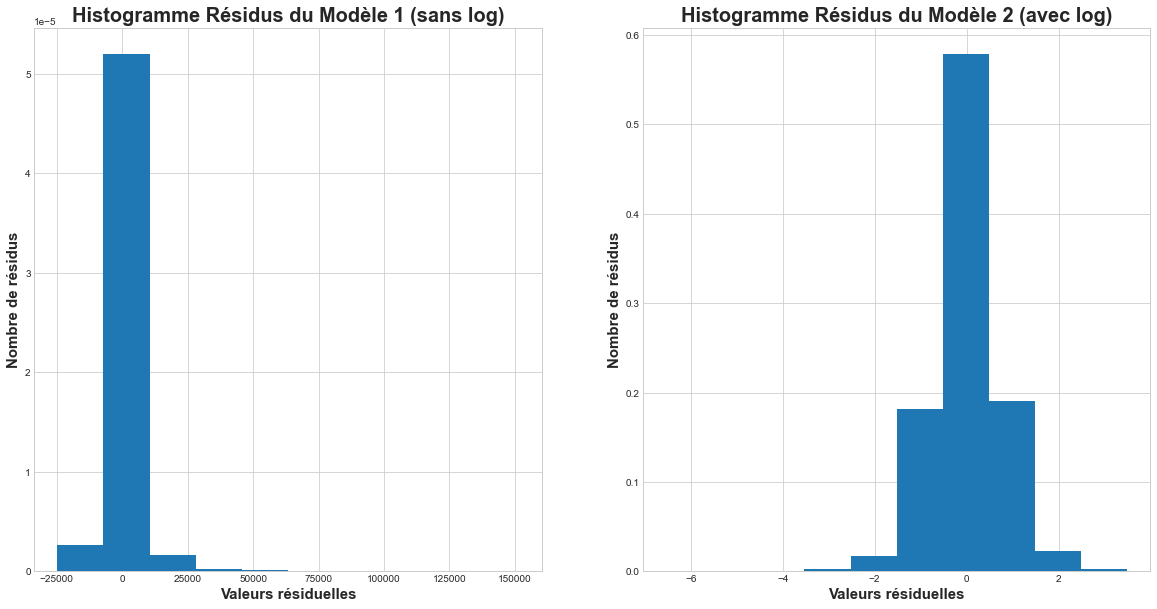

In [50]:
#Visualisation de la normalité des résidus : 
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.hist(RL1.resid, density=True)
plt.xlabel('Valeurs résiduelles', fontsize=15, fontweight='bold')
plt.ylabel('Nombre de résidus', fontsize=15, fontweight='bold')
plt.title('Histogramme Résidus du Modèle 1 (sans log)', fontsize=20, fontweight='bold')

plt.subplot(122)
plt.hist(RL2.resid, density=True)
plt.xlabel('Valeurs résiduelles', fontsize=15, fontweight='bold')
plt.ylabel('Nombre de résidus', fontsize=15, fontweight='bold')
plt.title('Histogramme Résidus du Modèle 2 (avec log)', fontsize=20, fontweight='bold')

#plt.savefig('residus.jpg')
plt.show()

**Observation :**
- Le modèle 1 (sans logarithme) renvoie une distribution des résidus qui semble suivre plus difficilement une loi normale, tandis que le second modèle propose une distribution plus gaussienne, plus homogène.

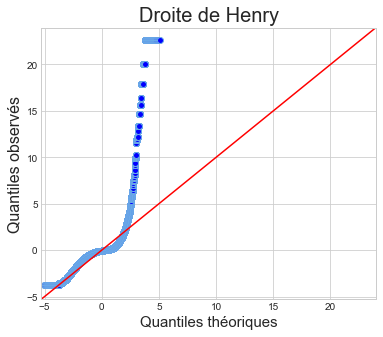

In [51]:
# Représentation graphique des résidus : droite de Henry
def residus_henry(MODEL, nom, couleur, ax):
    sm.qqplot(MODEL.resid, ax=ax, line="45", fit=True, color=couleur)
    ax.set_title("Droite de Henry", fontsize=20)
    ax.set_xlabel("Quantiles théoriques" ,fontsize=15), ax.set_ylabel("Quantiles observés", fontsize=16)
    
def analyse_des_residus(MODEL, nom, couleur):
    fig, (ax1) = plt.subplots(1, 1, figsize=(6, 5))
    residus_henry(MODEL, nom, couleur, ax1)
analyse_des_residus(RL1, "RL1", "#6CABE7") 
#plt.savefig('droit_henry_normal.jpg')
plt.show()

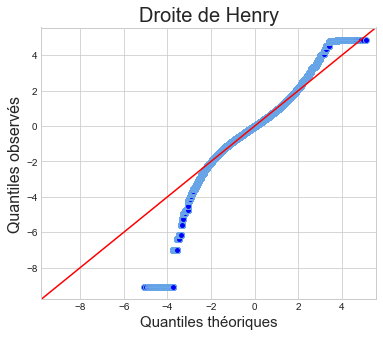

In [52]:
analyse_des_residus(RL2, "RL2", "#6CABE7") 
#plt.savefig('droit_henry_log.jpg')
plt.show()

**Observation :**
- on observe que les résidus du second modèle (passage aux logarithmes) suivent plus une loi normale que ceux du premier modèle. Le passage aux logarithmes permet donc d'avoir un modèle plus viable.

> **Test de colinéarité de nos deux modèles (Variance Inflation Factor)**

In [53]:
#Modèle 1 non logarithmique
variables = RL1.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.1459591695788411, 1.1459591695783005]

In [54]:
#Modèle 2 logarithmique
variables = RL2.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.0777076069535723, 1.0777076069548697]

**Observation :**
- En utilisant le VIF, il n'y aucun problème de colinéarité, en effet nos coefficients sont inférieurs à 10 et même à 5.

> **Test d’homoscédasticité (constance des variables ) par Breusch-Pagan**
- Ce test consiste à vérifier la constance de la variation des résidus. En cas d'hétéroscédasticité, la variance de l'erreur n'est pas constante. Dans le cas contraire, (hypothèse d'homoscédasticité) la variance de l'erreur est constante.

In [55]:
__, pval, __, f_pval = sms.het_breuschpagan(RL1.resid, RL1.model.exog)
print('Modèle 1 p value test Breusch-Pagan:', pval)

__, pval, __, f_pval = sms.het_breuschpagan(RL2.resid, RL2.model.exog)
print('Modèle 2 p value test Breusch-Pagan:', pval)

Modèle 1 p value test Breusch-Pagan: 0.0
Modèle 2 p value test Breusch-Pagan: 0.0


**Observation :**
- H0: Homoscédasticité et H1: Hétéroscédasticité
- - Rejet de l'hypothèse H0, il y a hétéroscédasticité des residus.
- Etant donné que nous travaillons sur un échantillon contenant plus de 5 Millions d'observations, le modèle de régression linéaire multiple reste robuste. De ce fait, il peut supporter des écarts importants aux hypothèses gaussiennes et homoscédastiques.
- En cas de Hétéroscédasticité, il y a 3 solutions possibles: 
- - Passer la variable explicative en Log.
- - Utilisé les valeurs en pourcentage plus tôt que les valeurs normales.
- -  Faire une régression pondérée.

> **Décomposition de la variance totale expliquée**

- Formule de décomposition de la variance SCT = SCE + SCR

In [56]:
res_regr_log = sms.anova_lm(RL3, typ=2)

#SCT
regr_log_sct = res_regr_log.values[:,0].sum()

#SCE
regr_log_sce = res_regr_log.values[0,0]+res_regr_log.values[1,0]

#SCR
regr_log_scr = res_regr_log.values[2,0]

#R2 squared
regr_log_r2 = regr_log_sce/regr_log_sct

In [57]:
#Variance expliquée par le revenu moyen du pays (log_m_j)
regr_log_sce_incomeavg = sm.stats.anova_lm(RL2, typ=2).values[1,0]/regr_log_sct
regr_log_sce_incomeavg

0.6885704968095308

In [58]:
#Variance expliquée par l'indice de Gini
regr_log_sce_gini = sm.stats.anova_lm(RL2, typ=2).values[0,0]/regr_log_sct
regr_log_sce_gini

0.011498721227417462

In [59]:
#Les résidus
regr_log_sce_residual = sm.stats.anova_lm(RL2, typ=2).values[2,0]/regr_log_sct
regr_log_sce_residual

0.29993072096607576

**Observation :**
- A partir de notre modèle **RL2**, nous pouvons conclure à un rôle clé du pays de naissance : 69% de la variance expliquée. L'indice de Gini compte pour seulement 1% de la variance.\ Puis le reste, les résidus

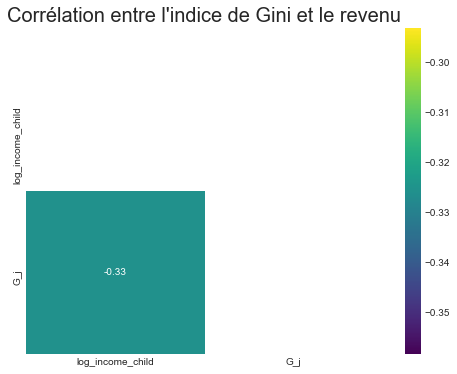

In [60]:
# Observation de corrélation entre le revenu et l'indice de Gini des pays
correlation_matrix = df_wid_500[['log_income_child', 'G_j']].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=np.bool))
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='viridis')

plt.title("Corrélation entre l'indice de Gini et le revenu", size=20)
#plt.savefig("corre.jpg")
plt.show()

 **Observation :**
 - On observe une corrélation négative entre les deux variables les plus explicatives : plus l'indice de Gini est bas, plus le revenu moyen a tendance à être haut.

> ### **Conclusion :**

- On obtient la **même performance avec les deux modèles (ANOVA et Régression Linéaire)**.
- Le passage aux logarithmes nous a permis d'avoir des modèles fiables, parce que, ce passage permet de se rapprocher d'une **distribution normale.**
- On peut conclure que le revenu d'un individu dépend du **revenu moyen de son pays d'origine** et de l'**indice de Gini**, cela a été expliqué à hauteur de **73% par l'analyse de la variance**. Le reste, ***27%***, est expliqué par de facteurs non considérés par le modèle comme la ***chance, niveau d'estudes, sexe, classe sociale, etc.***
- Plus l'indice de Gini du pays est faible, plus le revenu est élevé et inversement.

**Une question se pose concernant le coefficient de régression associé à l’indice de Gini, est-il possible d'affirmer que le fait de vivre dans un pays plus inégalitaire favorise plus de personnes qu’il n’en défavorise ?**

- Plus l’indice de Gini est élevé, plus les inégalités sont fortes, des écarts dans les salaires importants avec des revenus/individus plus bas dans le pays. L'exemple de modèle 2 est révélateur, on peut comprendre ce lien par le coefficient négatif au sein du modèle.